This notebook shows how trained models are used to make segmentation maps

First some imports and parameter settings

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

from keras.models import load_model
import keras

from utils import data_utils as du
from utils import preprocessing_utils as pu
from unet import unet_builder
import seaborn as sns
import pickle

Using TensorFlow backend.


In [36]:
from rasterio import logging

log = logging.getLogger()
log.setLevel(logging.ERROR)
np.set_printoptions(suppress=True)


# Increase dpi for figures to be at least 600 if you want to inspect them here or add to publications. 
plt.rcParams['figure.dpi'] = 200
plt.rcParams['savefig.dpi'] = 800

Next we do the following:
* Build model using utility
* Load weights
* Set locations for ground truth labels and input data

Input data can be geotiff, img or netcdf file. It should also have shape that is **even**, so no custom paddings are not needed.

You can try different models. Model 98-1.20.h5 had the best training accuracy and lowest training loss. 29-1.09.h5 had the lowest validation loss, and 74-1.12.h5 had best validation accuracy.

UPDATE 20.12.2018: 

Added three models, each trained with 9 images (one oversampling grasslands). I suggest that you use either model 98-1.20.h5 or 97-1.17.h5

In [3]:

model_2 = unet_builder.build_unet(14,13, activation='softmax')
model_2.load_weights('models/97-1.17.h5')


#ground_truth = '../input_pkarjala/jarjestetyt_tavoiteluokat.nc'
#test_bands = '../input_pkarjala/pkarjala__summer_s2_10m_9bands.tiff'
#test_indices = '../input_pkarjala/s2_indeksit_20180715-20180815.img'
ground_truth = '../input_marras2018/lopulliset_tavoiteluokat.nc'
test_bands = '../input_marras2018/patched_summer_2017.nc'
test_indices = '../input_marras2018/kaakonkulma_s2ind_20170601_20170831_rp.img'

Print summary for model, just to see what is there

In [4]:
model_2.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 1 0                                            
__________________________________________________________________________________________________
encoder_stage0_conv1 (Conv2D)   (None, None, None, 3 4032        input_1[0][0]                    
__________________________________________________________________________________________________
encoder_stage0_bn1 (BatchNormal (None, None, None, 3 128         encoder_stage0_conv1[0][0]       
__________________________________________________________________________________________________
encoder_stage0_relu1 (Activatio (None, None, None, 3 0           encoder_stage0_bn1[0][0]         
__________________________________________________________________________________________________
encoder_st

Open band and index images, and crop them a bit if needed (like if there are missing values on the borders). If images have shape that is not even, then crop them to be even.
If cropping is not necessary, comment line 
```
vals = vals[:,ycrop[0]:-ycrop[1], xcrop[0]:-xcrop[1]]
```


In [5]:
#xcrop = (0,1)
#ycrop = (0,1)

xcrop = (300,300)
ycrop = (300,301)

bands = xr.open_rasterio(test_bands)
indices = xr.open_rasterio(test_indices)

vals = np.vstack((bands.values, indices.values))
vals = vals[:,ycrop[0]:-ycrop[1], xcrop[0]:-xcrop[1]]
vals = vals.astype('float32')

C:\Users\E1005164\AppData\Local\Continuum\anaconda3\envs\lulc-ml-env\lib\site-packages\rasterio\__init__.py:193: UserWarning: Dataset has no geotransform set.  Default transform will be applied (Affine.identity())
  s.start()


Check that shape is even

In [6]:
vals.shape

(14, 5876, 6468)

Zero-center and normalize image. For now, use image values to normalize.

In [7]:
#with open('../notebooks/updated_train_means_19_12.obj', 'rb') as t:
#    train_means, train_std = pickle.load(t)

In [8]:
chan_means = []
chan_stds = []
for i in range(14):
    chan_mean = np.mean(vals[i])
    chan_std = np.std(vals[i])
    chan_means.append(chan_mean)
    chan_stds.append(chan_std)
    vals[i] = (vals[i] - chan_means[i]) / (chan_stds[i] + 1e-8)


In order to use sliding window method, the image must be sized so that it's a multiple of both width and height. This is done by mirroring the data on the border. Example: we have an array \[1,2,2,7,5\] that should be mirrored from the left to be 7 elements long. New array is \[2,2,1,2,2,7,5\].

In [9]:
import math
chans = 14
width = 256
height = 256
class_band = 0
x_start = 0
y_start = 0

x_pad = (math.ceil(vals.shape[2] / width) * width - vals.shape[2])//2
y_pad = (math.ceil(vals.shape[1] / height) * height - vals.shape[1])//2
padded_vals = np.pad(vals, ((0,0), (y_pad, y_pad), (x_pad, x_pad)), 'reflect')
x_end = padded_vals.shape[2]
y_end = padded_vals.shape[1]
steps = ((x_end - x_start) // width) * ((y_end - y_start) // height)
print(vals.shape, padded_vals.shape, steps)

(14, 5876, 6468) (14, 5888, 6656) 598


data_utils.sub_image_generator is a generator function that creates subimages in certain order. With that, we can use predict_generator() from keras to make the predictions. 

In [10]:
pred = model_2.predict_generator(du.sub_image_generator(padded_vals, 0, padded_vals.shape[2], width, 
                                                        0, padded_vals.shape[1], height, chans), 
                                                        steps=steps, workers=1, max_queue_size=40, verbose=1)

598/598 [==============================] - 892s 1s/step


Next we make hard classification for predictions (\[0.1, 0.3, 0.1, 0.5\] becomes 3 and so on) and untile these predictions.

In [11]:
print(pred.shape)
full_image = du.create_full_image(np.argmax(pred, axis=-1), x_start, x_end, y_start, y_end)

print(full_image.shape)

(598, 256, 256, 13)
(6656, 5888)


Then the padding is removed.

In [12]:
unpadded_image = full_image[x_pad:-x_pad, y_pad:-y_pad]

Check that shape matches

In [13]:
unpadded_image.shape

(6468, 5876)

We might have some uses for prediction distributions, so let's untile them as well.

In [14]:
full_preds = du.untile_preds(pred, x_start, x_end, y_start, y_end)[x_pad:-x_pad, y_pad:-y_pad,...].swapaxes(0,1)

Open ground truth labels, crop them and make labels start from zero.

If cropping is not necessary, replace 

```
truth_cust = truth[0, ycrop[0]:-ycrop[1], xcrop[0]:-xcrop[1]].values
```

with

```
truth_cust = truth[0].values
```

In [15]:
truth = xr.open_dataarray(ground_truth)
truth_cust = truth[0, ycrop[0]:-ycrop[1], xcrop[0]:-xcrop[1]].values
truth_cust[~np.isnan(truth_cust)] -= 1
truth_cust.shape

(5876, 6468)

Make predictions have same axis order than ground truth

In [16]:
unpadded_image = unpadded_image.T
unpadded_image = unpadded_image.astype('float32')

Mask all values that have missing reflectances in corine mosaic.

If cropping is not necessary, replace with 

```
truth_cust[bands[0].values == 0] = np.nan
unpadded_image[bands[0].values == 0] = np.nan
```

In [17]:
truth_cust[bands[0, ycrop[0]:-ycrop[1], xcrop[0]:-xcrop[1]].values == 0] = np.nan
unpadded_image[bands[0, ycrop[0]:-ycrop[1], xcrop[0]:-xcrop[1]].values == 0] = np.nan

Check class distributions in order to see if any mistakes were made

Text(0.5,1,'Prediction')

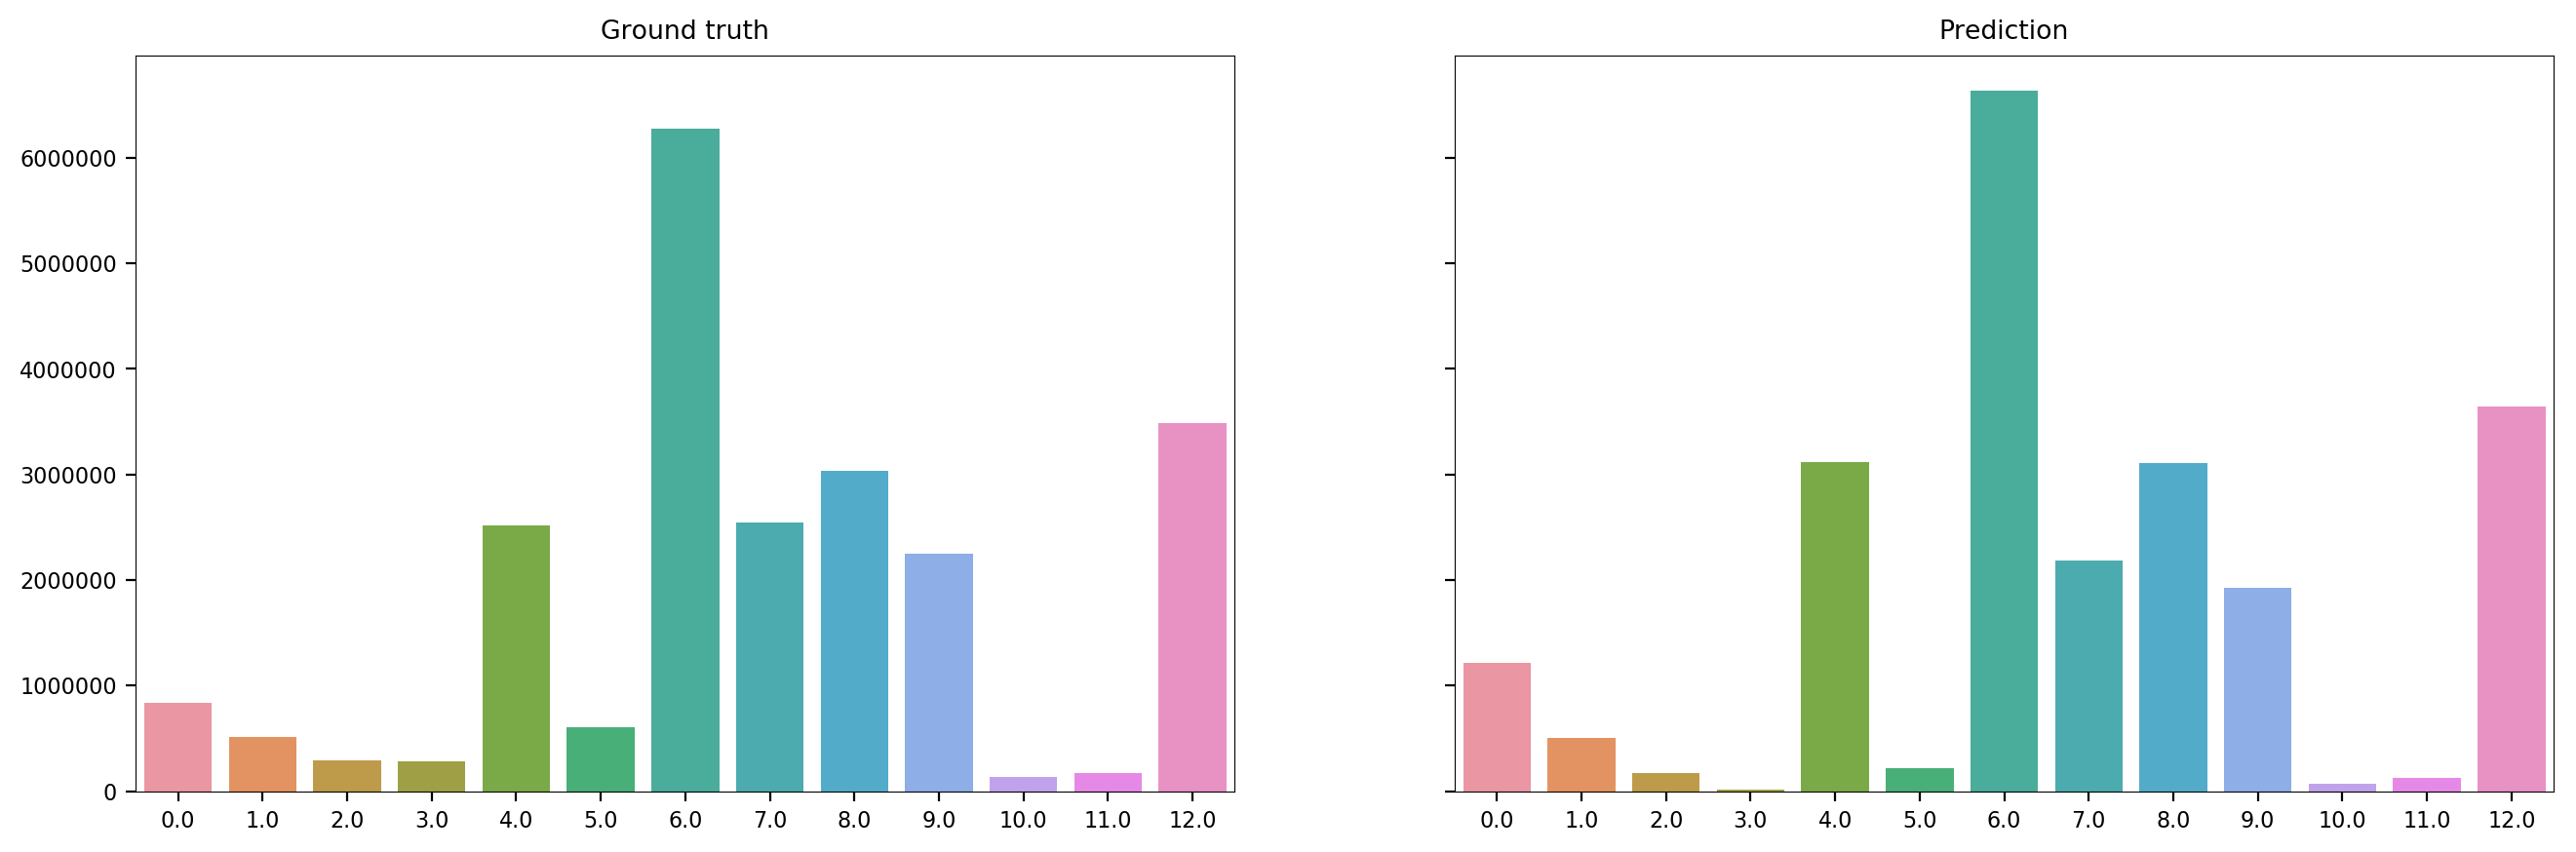

In [37]:
f, (ax1,ax2) = plt.subplots(ncols=2,figsize=(16,5), sharey=True,
                            gridspec_kw={"width_ratios":[1, 1]})
truth_uniq, truth_counts = np.unique(truth_cust[~np.isnan(truth_cust)], return_counts=True)


sns.barplot(truth_uniq, truth_counts, ax=ax1).set_title('Ground truth')
uniq, counts = np.unique(unpadded_image[~np.isnan(truth_cust)], return_counts=True)
sns.barplot(uniq, counts, ax=ax2).set_title('Prediction')


Scikit-learn gives useful functions for us, so first lets check accuracies for predictions. Accuracy score is overall accuracy, while balanced score is average recall.

In [19]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score
print(accuracy_score(truth_cust[~np.isnan(truth_cust)].ravel(), unpadded_image[~np.isnan(truth_cust)].ravel()))
print(balanced_accuracy_score(truth_cust[~np.isnan(truth_cust)].ravel(), unpadded_image[~np.isnan(truth_cust)].ravel()))

0.698332747041726
0.5430932934147136


Classification report shows labelwise, micro, macro and weighted precision, recall and f1-scores. They are definded as follows:
* Macro is unweighted mean of all labelwise values
* Weighted values are, well, weighted with the proportion of different classes
* Micro is calculated such that sum up the individual true positives, false positives, and false negatives of the system for different sets and the apply them to get the statistics. 
* Precision is TP / (TP + FP), "how many selected items are relevant"
* Recall is TP / (TP + FN), "how many relevant items are selected"
* F1-score is harmonic mean of precision and recall, (2 * pre * rec) / (pre + rec)

In [20]:
from sklearn.metrics import classification_report

reduced_class_names = ['Built-up areas, sparse',
                       'Built-up areas, dense',
                       'Bare areas',
                       'Grasslands',
                       'Fields',
                       'Broad-leaved forest',
                       'Pine-dominated coniferous forest',
                       'Spruce-dominated coniferous forest',                       
                       'Mixed forest',
                       'Transitional woodland shrub',
                       'Inland marshes',
                       'Water vegetation',
                       'Water bodies']
print(classification_report(truth_cust[~np.isnan(truth_cust)].ravel(), unpadded_image[~np.isnan(truth_cust)].ravel(), 
                            target_names = reduced_class_names))

                                    precision    recall  f1-score   support

            Built-up areas, sparse       0.48      0.70      0.57    840932
             Built-up areas, dense       0.51      0.50      0.51    515012
                        Bare areas       0.65      0.38      0.48    292172
                        Grasslands       0.34      0.02      0.04    278496
                            Fields       0.75      0.93      0.83   2513372
               Broad-leaved forest       0.61      0.22      0.32    608832
  Pine-dominated coniferous forest       0.70      0.74      0.72   6275812
Spruce-dominated coniferous forest       0.62      0.53      0.57   2544172
                      Mixed forest       0.57      0.58      0.58   3030588
       Transitional woodland shrub       0.65      0.56      0.60   2252320
                    Inland marshes       0.78      0.42      0.55    135564
                  Water vegetation       0.67      0.49      0.57    167856
           

Confusion matrices shown here are unnormalized

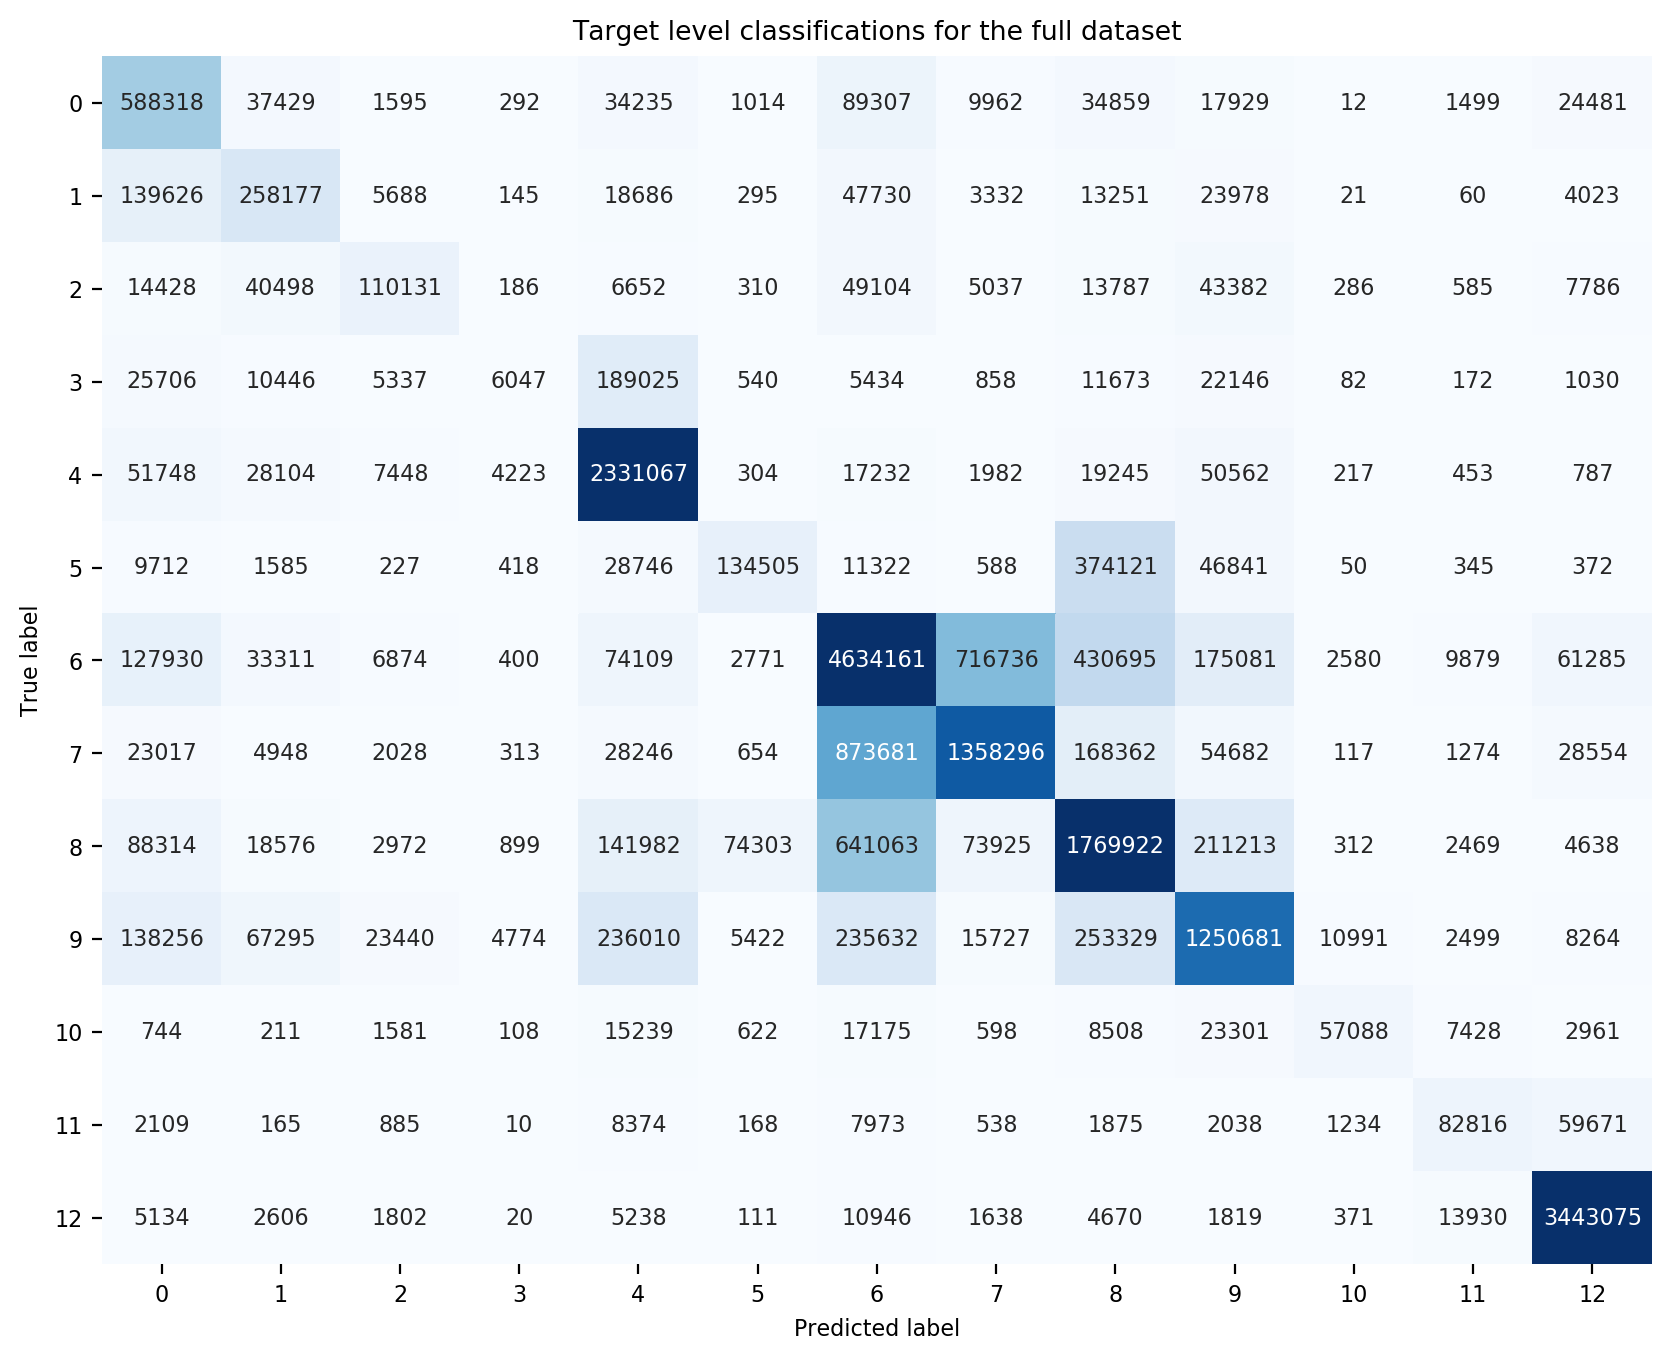

In [38]:
from sklearn.metrics import confusion_matrix
np.set_printoptions(suppress=True)
plt.rcParams["figure.figsize"] = (10, 8)

cm = confusion_matrix(truth_cust[~np.isnan(truth_cust)].ravel(), unpadded_image[~np.isnan(truth_cust)].ravel())

sns.heatmap(cm, annot=True, fmt='d', xticklabels=range(0,13), yticklabels=range(0,13),
            cbar=False, robust=True, cmap='Blues').set_title('Target level classifications for the full dataset')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.yticks(rotation=0)
plt.show()

Function for Jaccard index (Intersection over Union) is faulty in scikit learn, so function for it and compute it. First we get classwise scores and then overall score. Image from wikipedia.

![IoU](https://upload.wikimedia.org/wikipedia/commons/c/c7/Intersection_over_Union_-_visual_equation.png)

In [22]:
def compute_iou(y_pred, y_true):
    y_pred = y_pred.flatten()
    y_true = y_true.flatten()
    current = confusion_matrix(y_true, y_pred, labels=range(int(np.max(y_pred)) + 1))
    intersection = np.diag(current)
    ground_truth_set = current.sum(axis=1)
    predicted_set = current.sum(axis=0)
    union = ground_truth_set + predicted_set - intersection
    IoU = intersection / union.astype(np.float32)
    print(IoU)
    print(np.mean(IoU))
    return np.mean(IoU)

In [23]:
compute_iou(truth_cust[~np.isnan(truth_cust)].ravel(), unpadded_image[~np.isnan(truth_cust)].ravel())

[0.40085551 0.33962346 0.31282861 0.02083132 0.70640235 0.19343607
 0.55951836 0.40244698 0.40548385 0.42754057 0.37598214 0.39729622
 0.93176657]
0.4210778475200012


0.4210778475200012

Let's visualize some results. First predicted labels compared to CLC 2018 ones

In [24]:
plt.rcParams['font.size'] = 8
plt.rcParams['axes.linewidth'] = 0.4

Show map for area

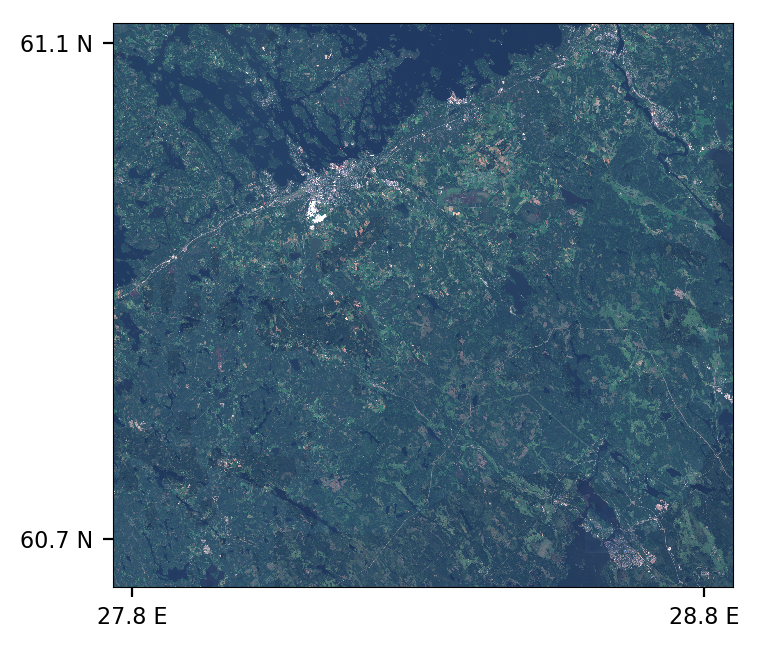

In [39]:
f, ax = plt.subplots(ncols=1, nrows=1, figsize=(4,4))
plt.setp([ax], xticks=[200, 6167], xticklabels=['27.8 E', '28.8 E'],
        yticks=[200,5375], yticklabels=['61.1 N', '60.7 N'])

mapview = np.empty((3, vals.shape[1], vals.shape[2]))
mapview[0:3,...] = bands.values[2::-1, ycrop[0]:-ycrop[1], xcrop[0]:-xcrop[1]] / 2000
mapview = np.moveaxis(mapview, 0, 2)
plt.imshow(mapview)

Show classification comparisons

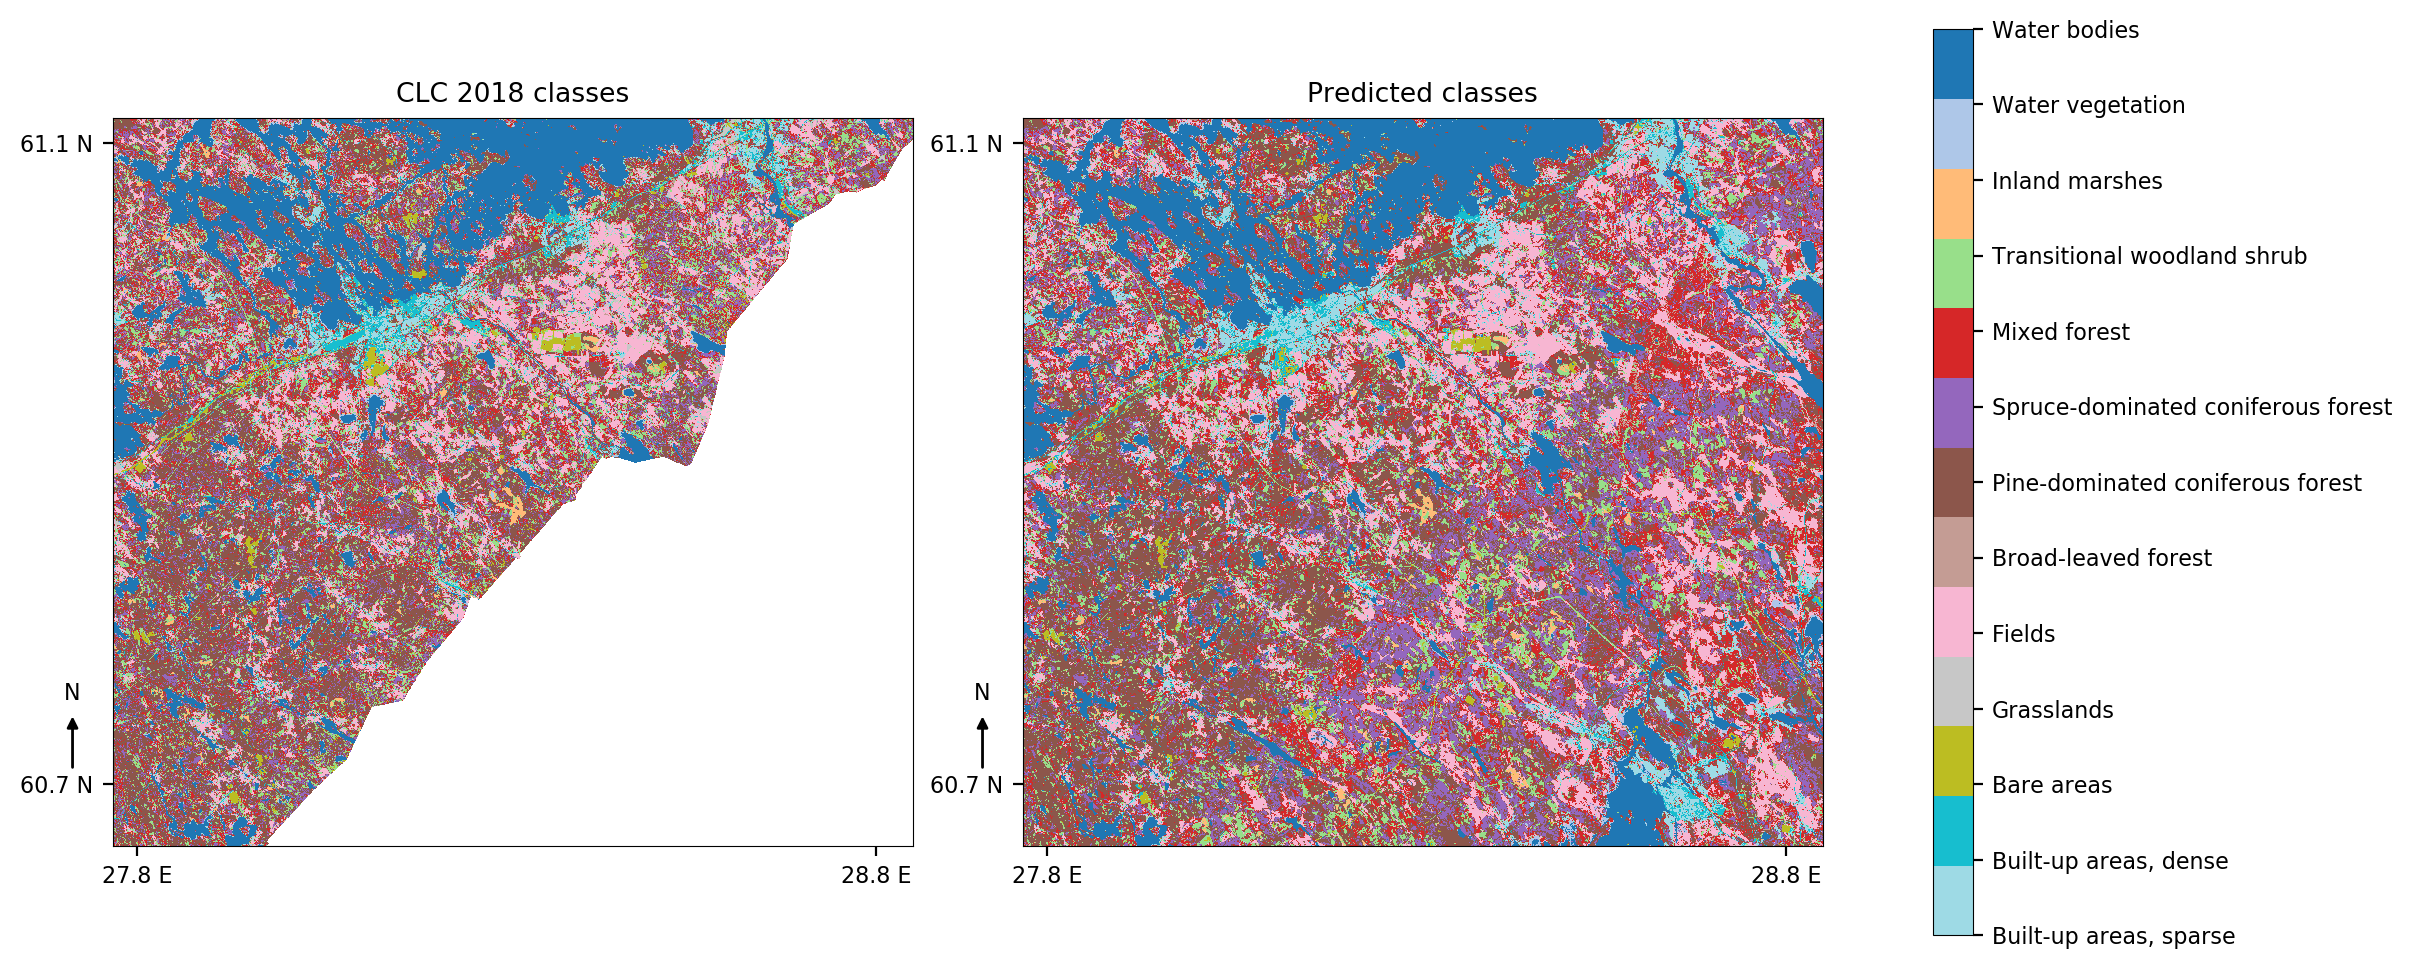

In [40]:
from matplotlib.colors import ListedColormap

f, (ax1, ax3, ax4) = plt.subplots(ncols=3, figsize=(12,6),
                                  gridspec_kw={"width_ratios":[1,1, 0.05]})

# This can be used to add custom ticks to images. Change to suit your needs
plt.setp([ax1, ax3], xticks=[200, 6167], xticklabels=['27.8 E', '28.8 E'],
        yticks=[200,5375], yticklabels=['61.1 N', '60.7 N'])
    
ax4.set_xticks([])
ax4.set_yticks([])

truth = truth_cust
preds = unpadded_image
colormap = ListedColormap(plt.cm.tab20(np.linspace(1,0,len(reduced_class_names))))
labels = reduced_class_names


# These add north arrow annotations
ax1.annotate('N', xy=(-0.05, 0.10), xycoords='axes fraction', xytext=(-0.05, 0.20), 
            arrowprops=dict(arrowstyle="<|-", color='black'), horizontalalignment='center')
ax3.annotate('N', xy=(-0.05, 0.10), xycoords='axes fraction', xytext=(-0.05, 0.20), 
            arrowprops=dict(arrowstyle="<|-", color='black'), horizontalalignment='center')
ax1.set_title('CLC 2018 classes')
im1 = ax1.imshow(truth, vmin=0, vmax=len(labels)-1, cmap=colormap)
ax3.set_title('Predicted classes')
im2 = ax3.imshow(preds, vmin=0, vmax=len(labels)-1, cmap=colormap)

cbar = f.colorbar(im1, cax=ax4, ticks=range(0,len(labels), 1))
cbar.set_ticklabels(labels)
plt.show()

Highlight only some classes, say Grasslands

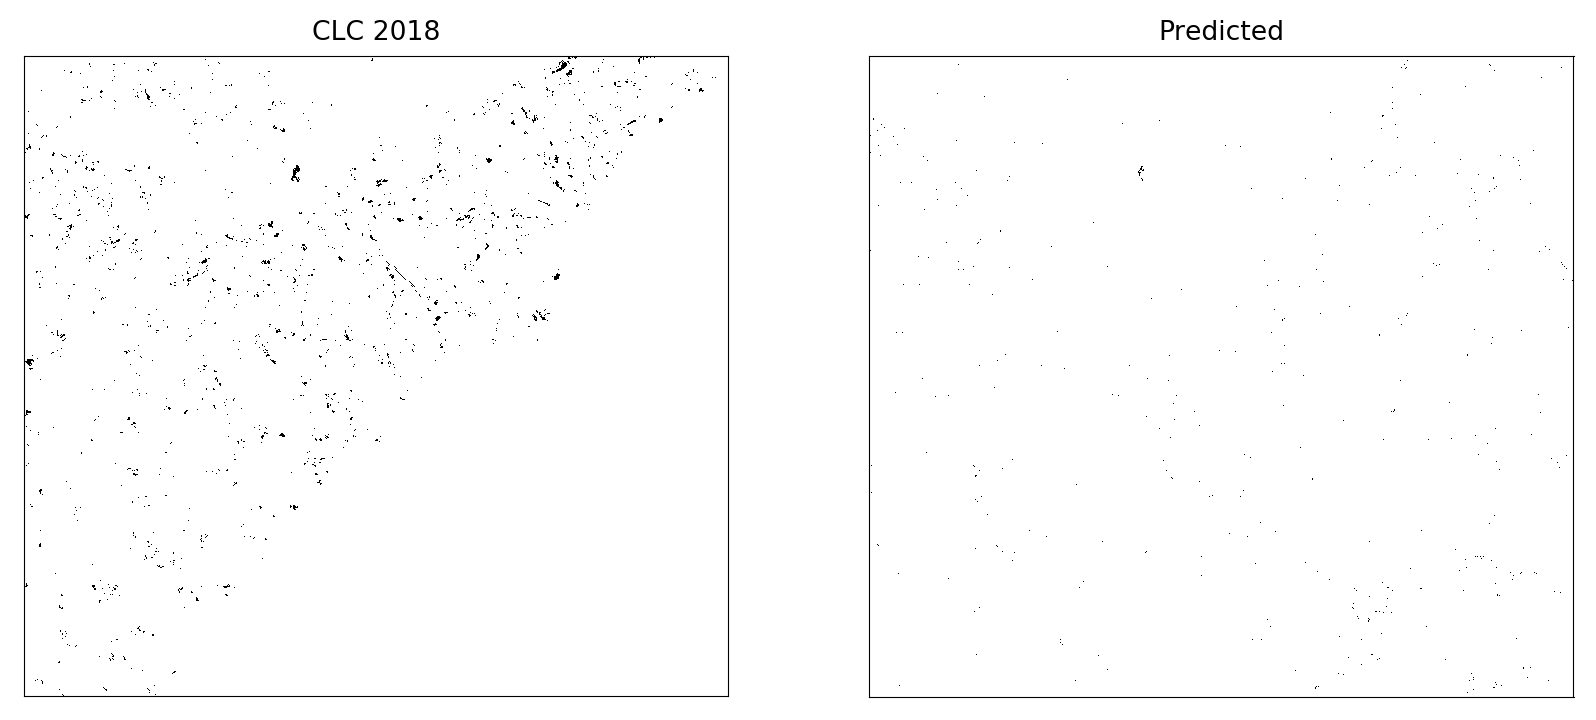

In [41]:
f, (ax1, ax3) = plt.subplots(ncols=2)

plt.setp([ax1, ax3], xticks=[], xticklabels=[],
        yticks=[], yticklabels=[])
    
true_grasslands = truth_cust.copy()
pred_grasslands = unpadded_image.copy()
colormap = ListedColormap(plt.cm.tab20(np.linspace(1,0,len(reduced_class_names))))
labels = ['Not grasslands', 'Grasslands']
true_grasslands[true_grasslands != 3] = 0
pred_grasslands[pred_grasslands != 3] = 0
true_grasslands[true_grasslands != 0] = 1
pred_grasslands[pred_grasslands != 0] = 1
#ax2.set_title('Map view')
#mapview = np.empty((truth.shape[0], truth.shape[1], 3))
#mapview[:,:,0] = vals[2,:,:] / 2000
#mapview[:,:,1] = vals[1,:,:] / 2000
#mapview[:,:,2] = vals[0,:,:] / 2000
#im3 = ax2.imshow(mapview)

#ax1.annotate('N', xy=(-0.05, 0.10), xycoords='axes fraction', xytext=(-0.05, 0.20), 
#            arrowprops=dict(arrowstyle="<|-", color='black'), horizontalalignment='center')
#ax3.annotate('N', xy=(-0.05, 0.10), xycoords='axes fraction', xytext=(-0.05, 0.20), 
#            arrowprops=dict(arrowstyle="<|-", color='black'), horizontalalignment='center')
ax1.set_title('CLC 2018')
im1 = ax1.imshow(true_grasslands, cmap='binary')
ax3.set_title('Predicted')
ax3.imshow(pred_grasslands, cmap='binary')

plt.show()

Then check how "correct" the predictions are. These values are calculated as L2-distance between correct prediction, for instance \[0,1,0,0,0\] for label 1 and prediction, such as \[0.05, 0.8, 0.05, 0.02, 0.08\].

C:\Users\E1005164\AppData\Local\Continuum\anaconda3\envs\lulc-ml-env\lib\site-packages\numpy\linalg\linalg.py:2390: RuntimeWarning: invalid value encountered in sqrt
  return sqrt(add.reduce(s, axis=axis, keepdims=keepdims))


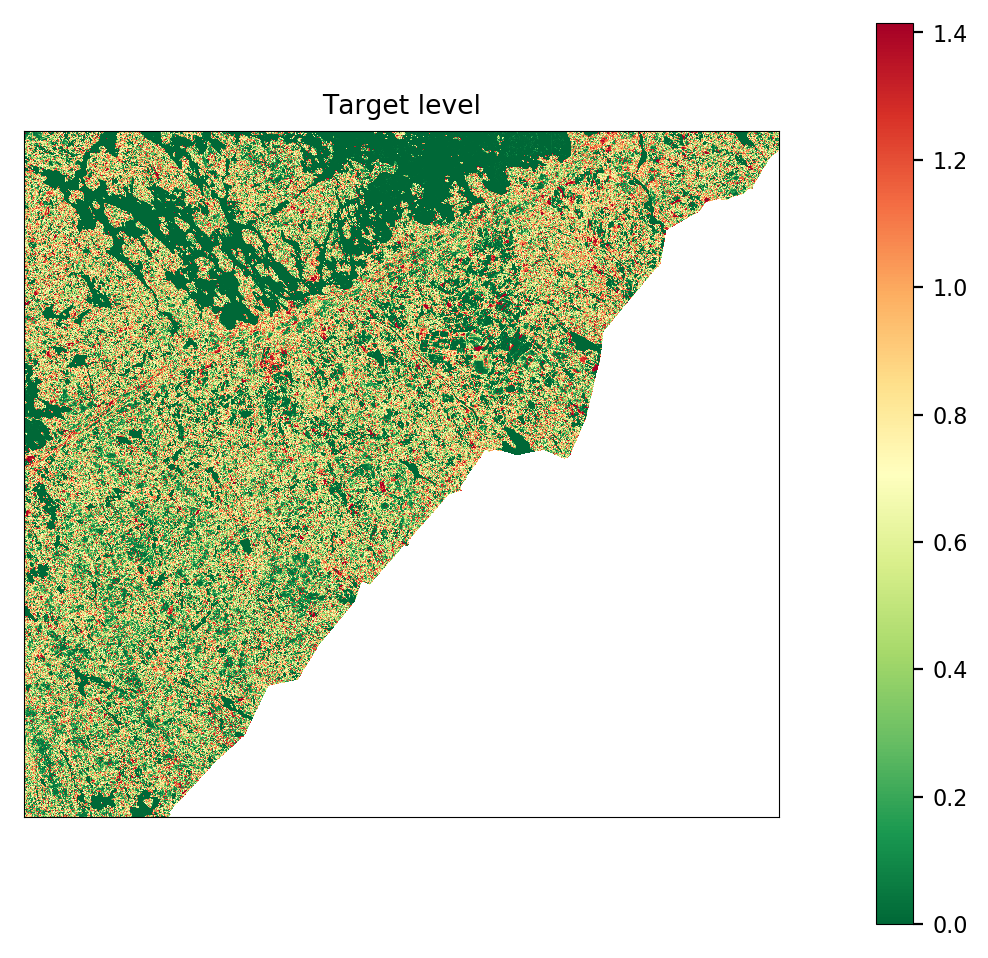

In [42]:
from keras.utils import to_categorical


f, (ax1, cax) = plt.subplots(ncols=2, figsize=(5,5), gridspec_kw={'width_ratios': [1,0.05]})
f.tight_layout()
plt.setp([ax1], xticks=[], xticklabels=[],
        yticks=[], yticklabels=[])
#ax1.annotate('N', xy=(-0.05, 0.10), xycoords='axes fraction', xytext=(-0.05, 0.20), 
#            arrowprops=dict(arrowstyle="<|-", color='black'), horizontalalignment='center')

truth_no_nan = np.nan_to_num(truth_cust)
diff_pred = np.linalg.norm(to_categorical(truth_no_nan) - full_preds, axis=-1)
ax1.set_title('Target level')

diff_pred[np.isnan(truth_cust)] = np.nan
im1 = ax1.imshow(diff_pred, cmap='RdYlGn_r')


cbar = f.colorbar(im1, cax=cax)

plt.show()


Print classwise predictions

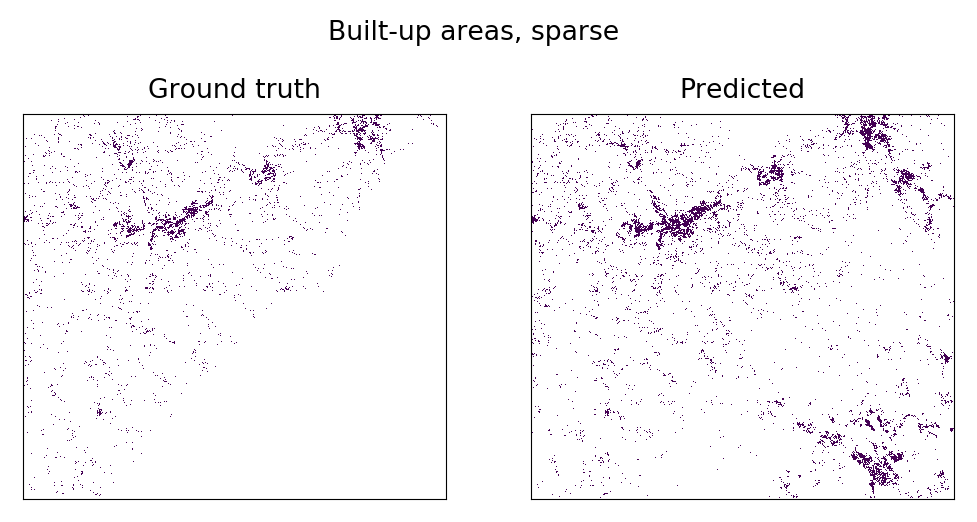

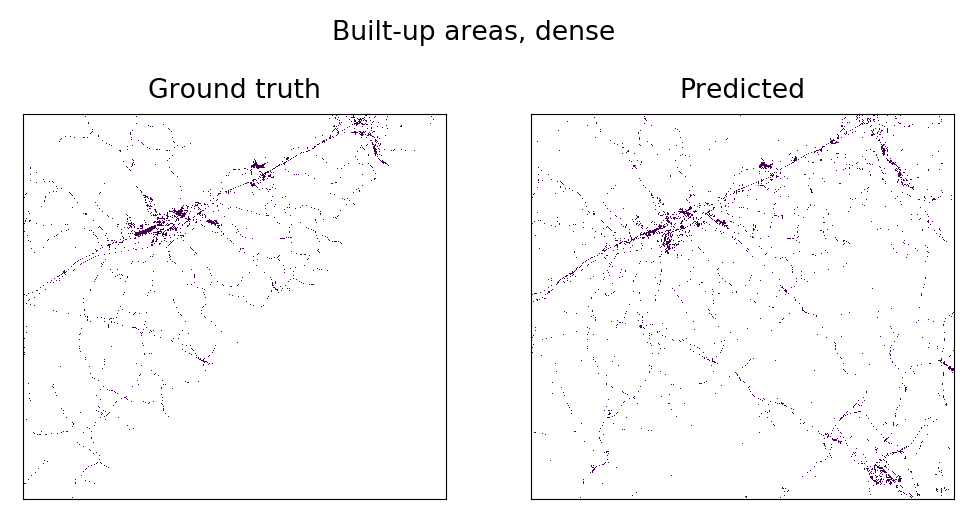

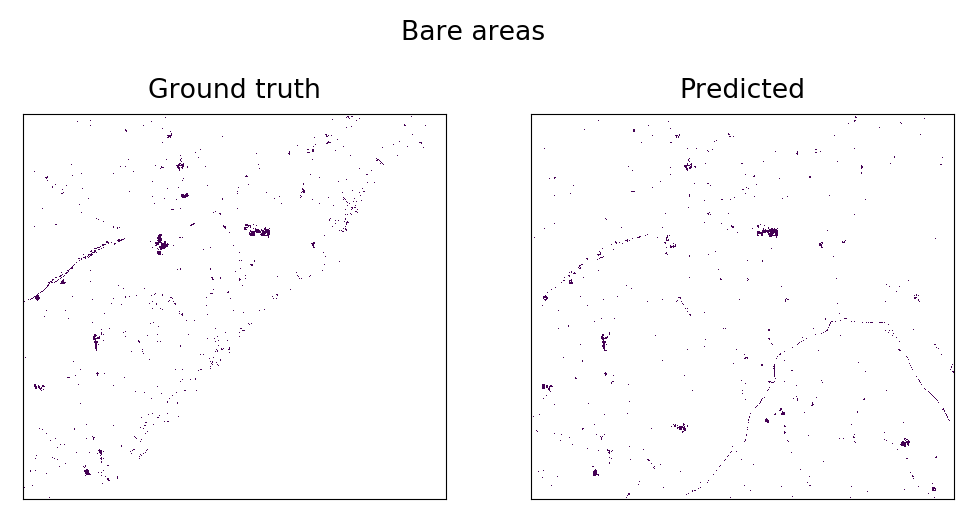

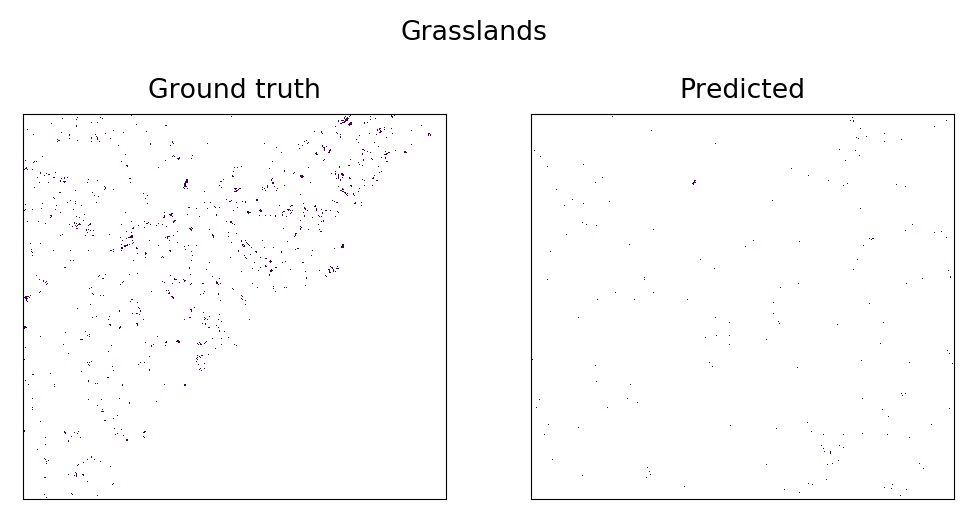

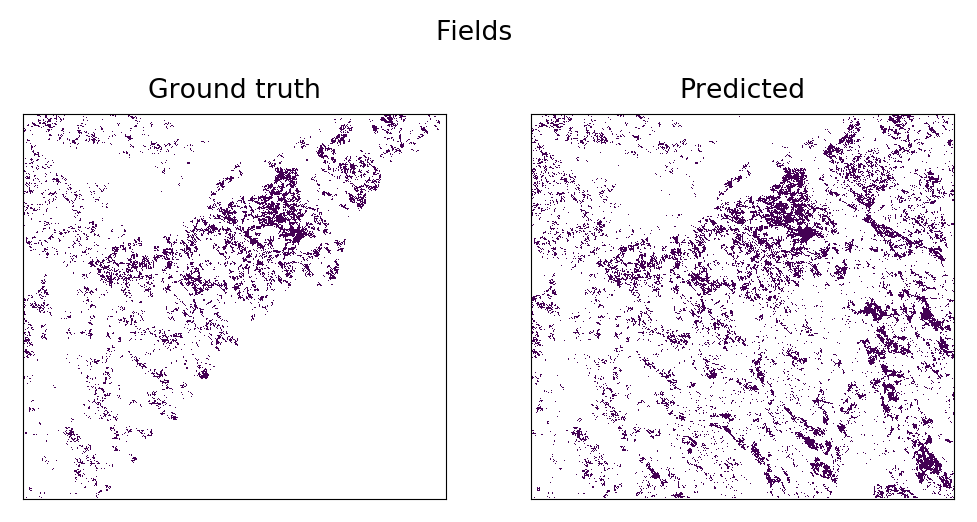

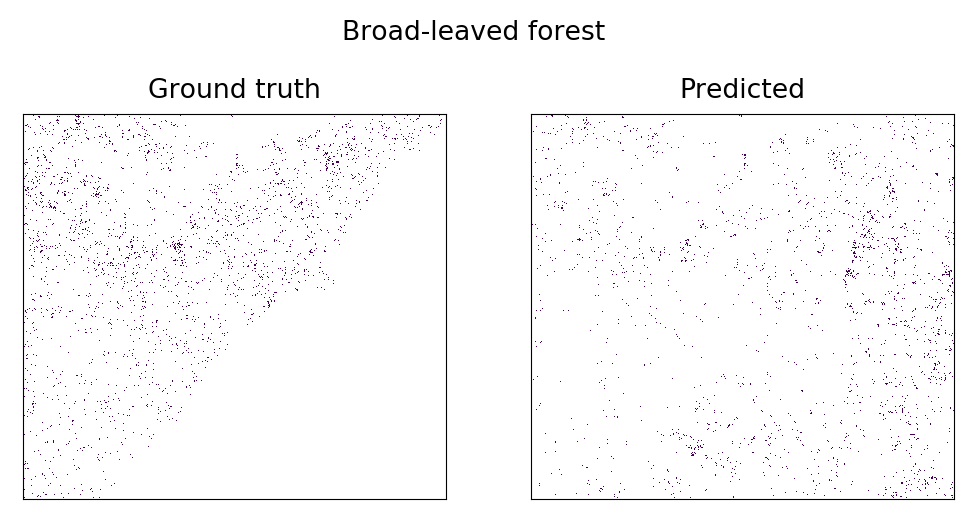

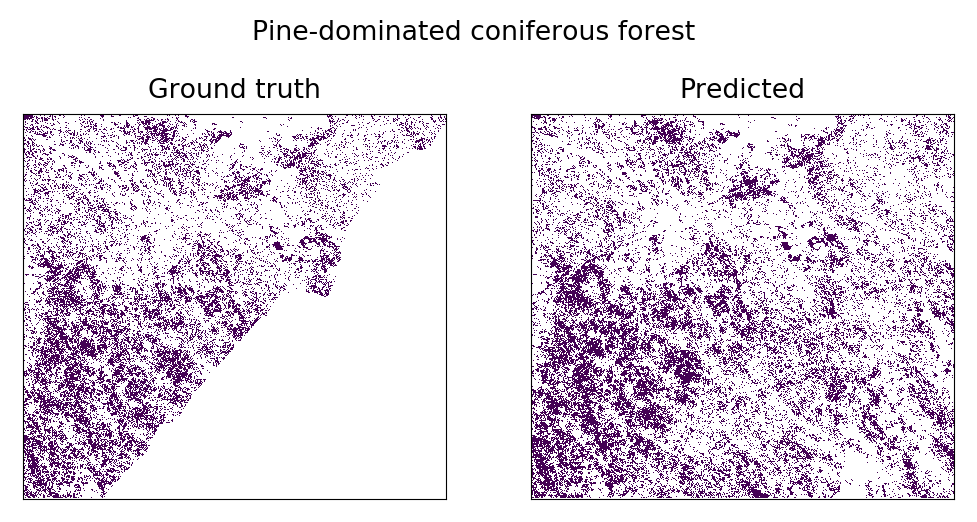

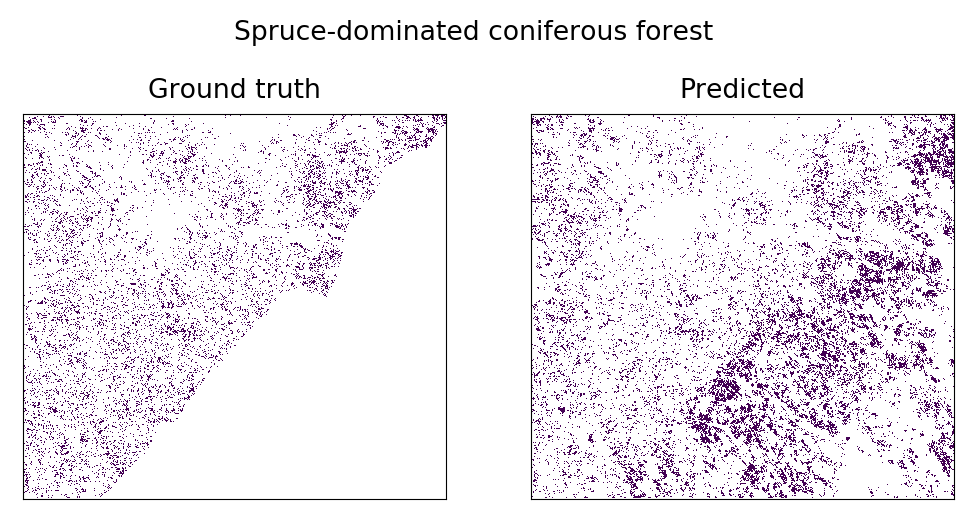

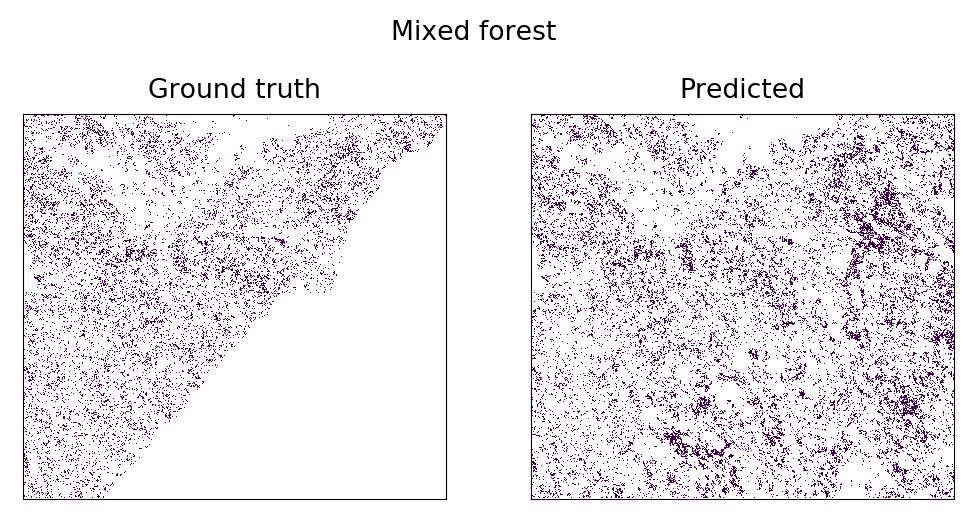

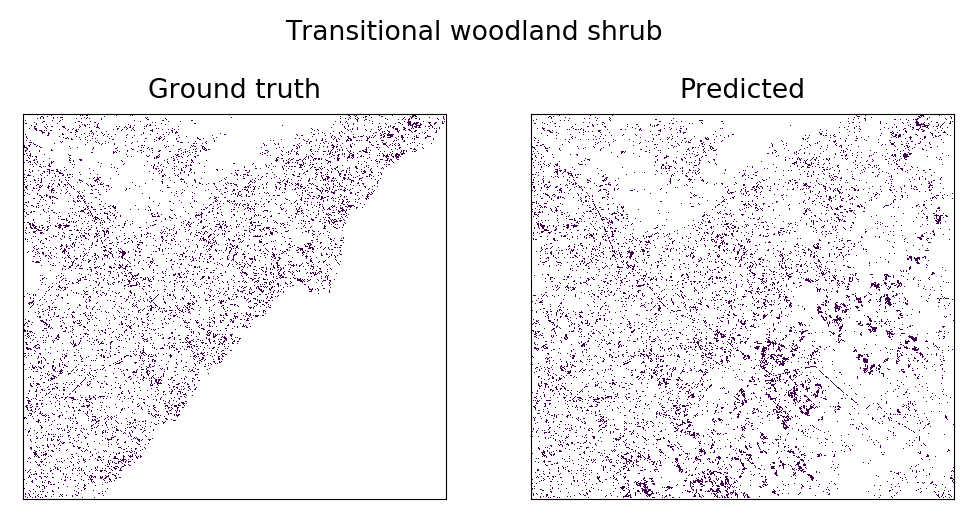

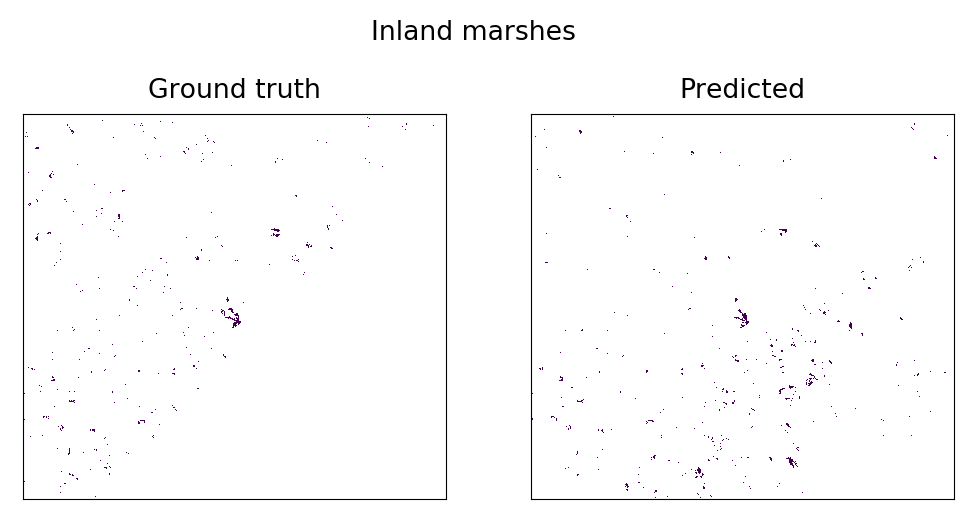

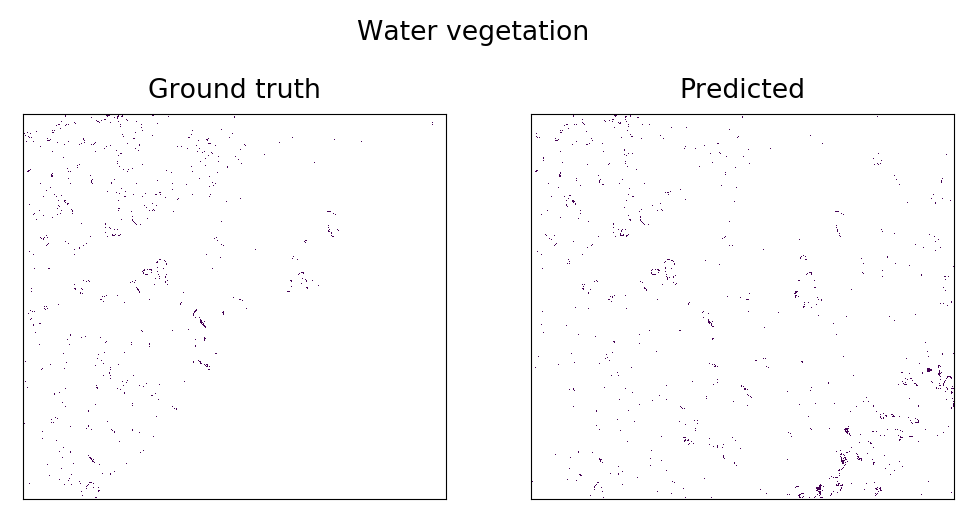

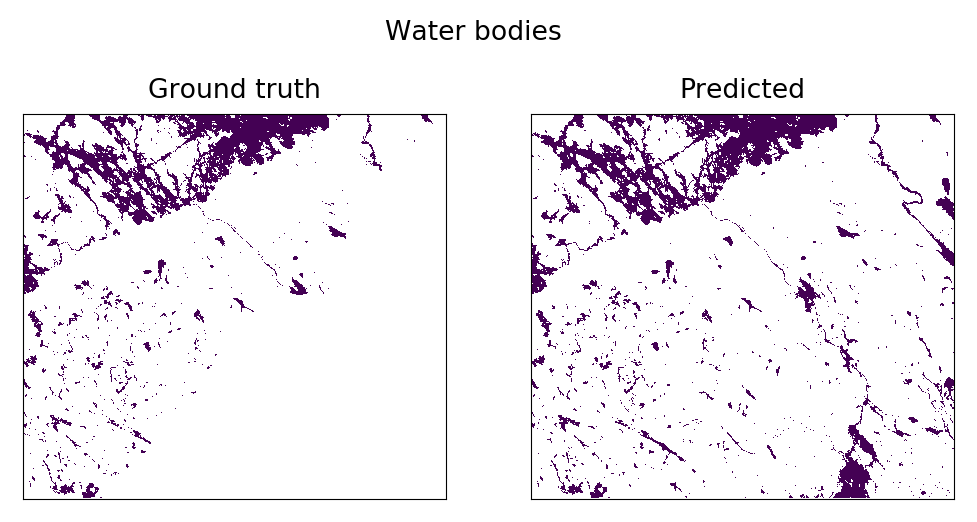

In [43]:
for i in range(13):
    f, ax = plt.subplots(1,2, figsize=(6,3))
    plt.setp(ax, xticks=[], yticks=[])
    plt.suptitle(f'{reduced_class_names[i]}')
    ax[0].imshow(np.ma.masked_where(truth != i, truth))
    ax[1].imshow(np.ma.masked_where(preds != i, preds))
    ax[0].set_title('Ground truth')
    ax[1].set_title(f'Predicted')
    plt.show()

Print activation maps for different classes

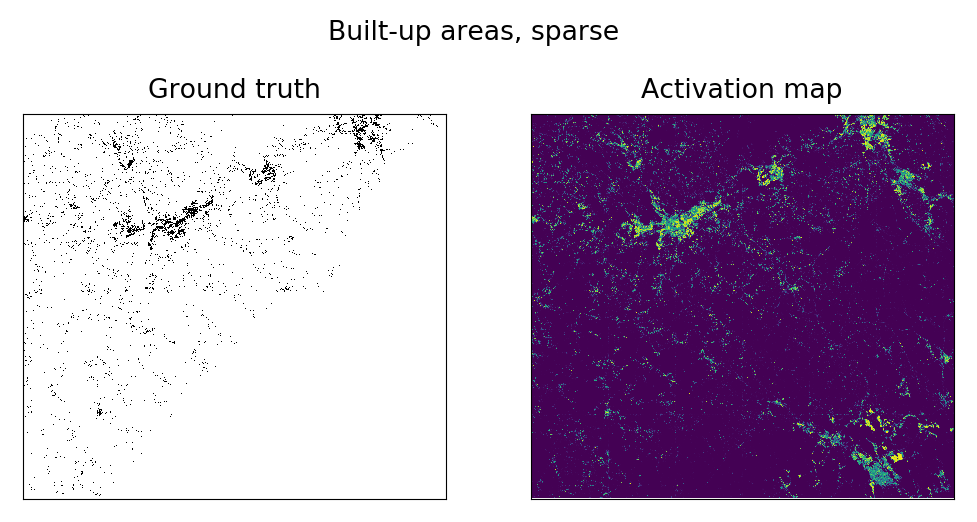

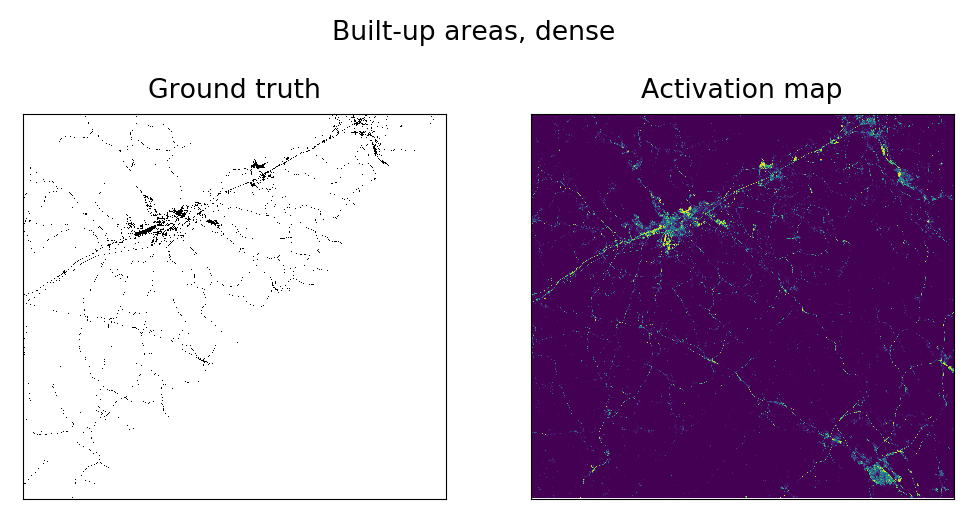

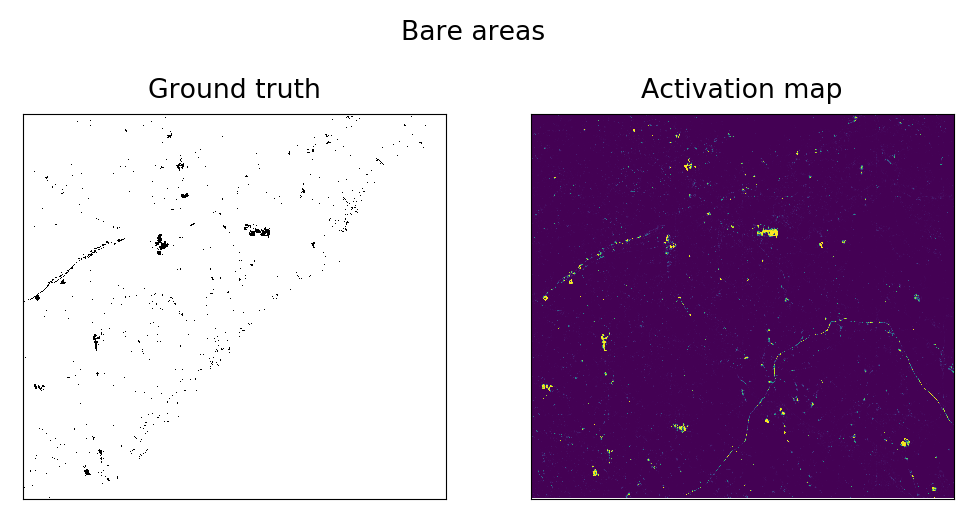

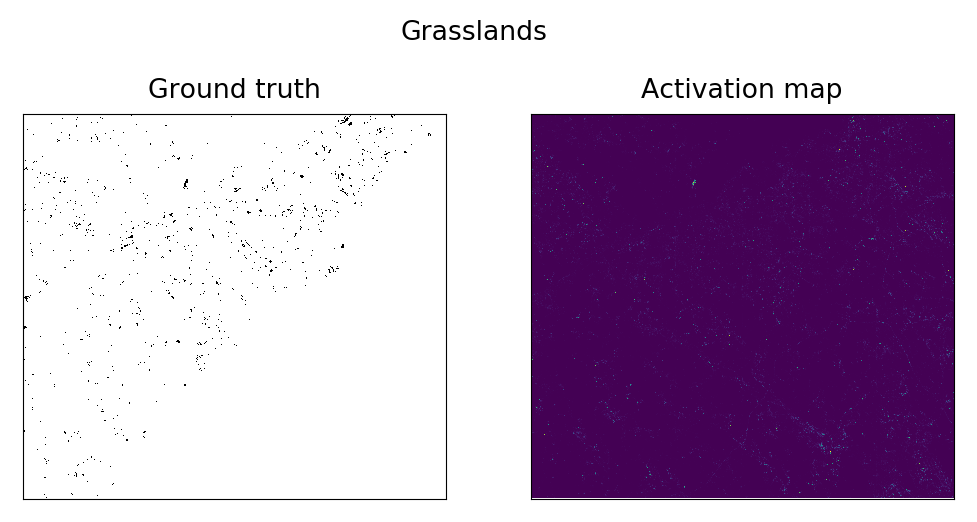

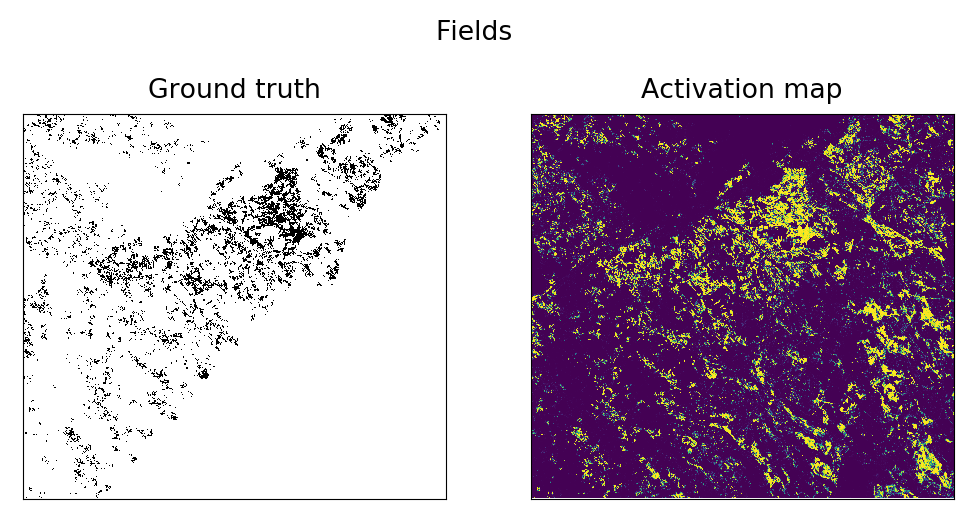

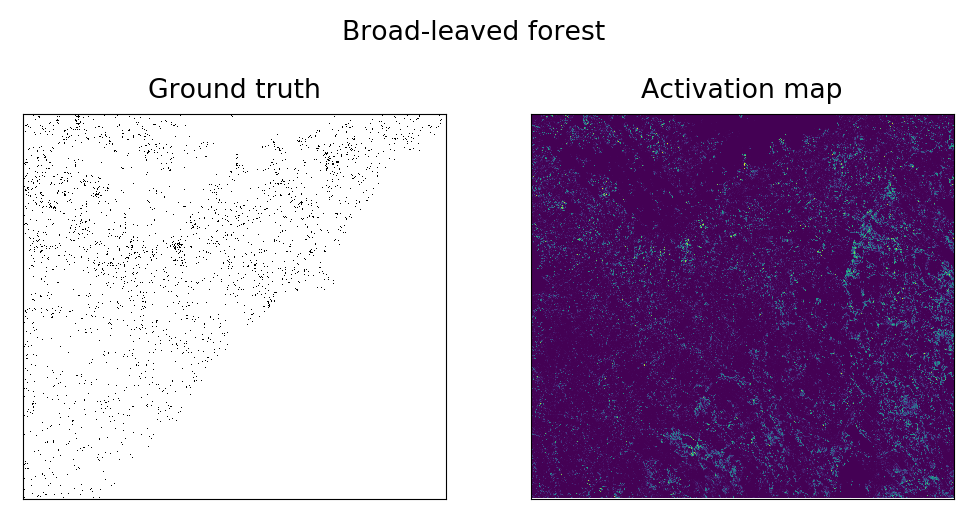

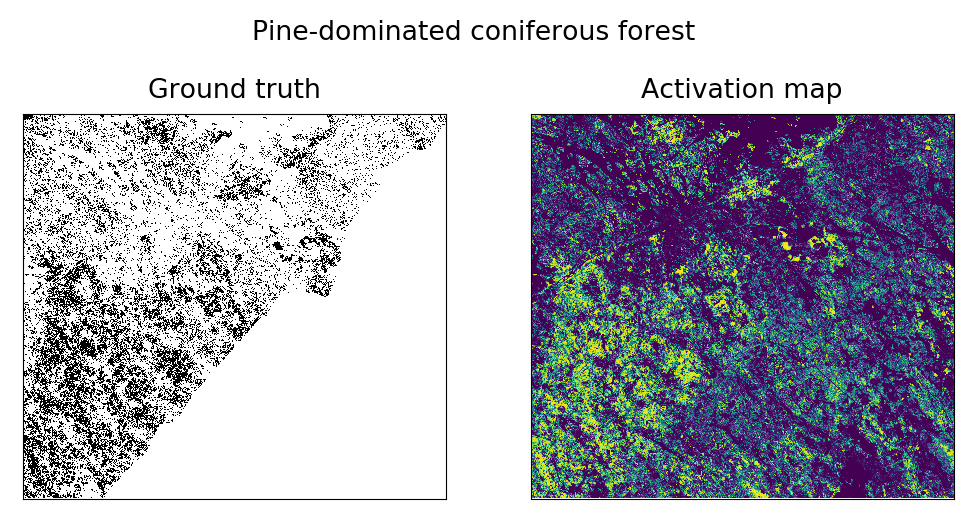

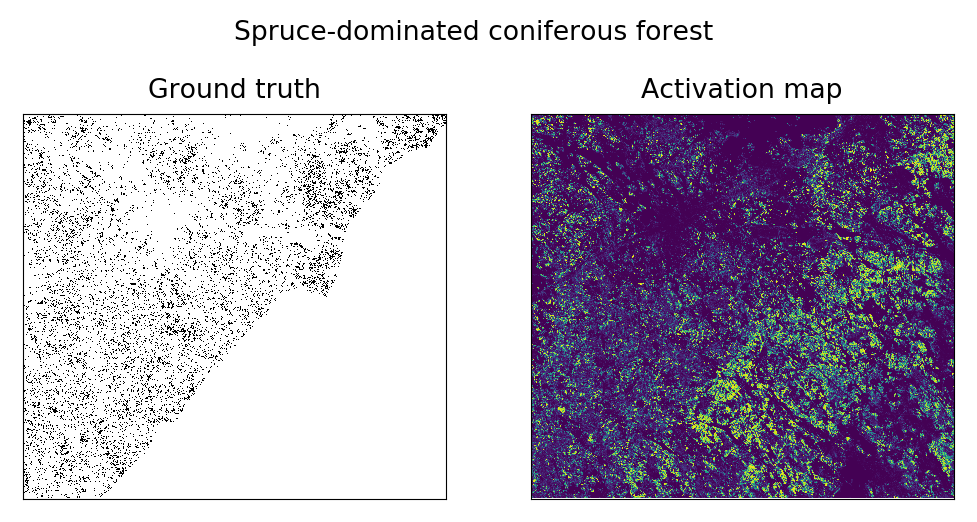

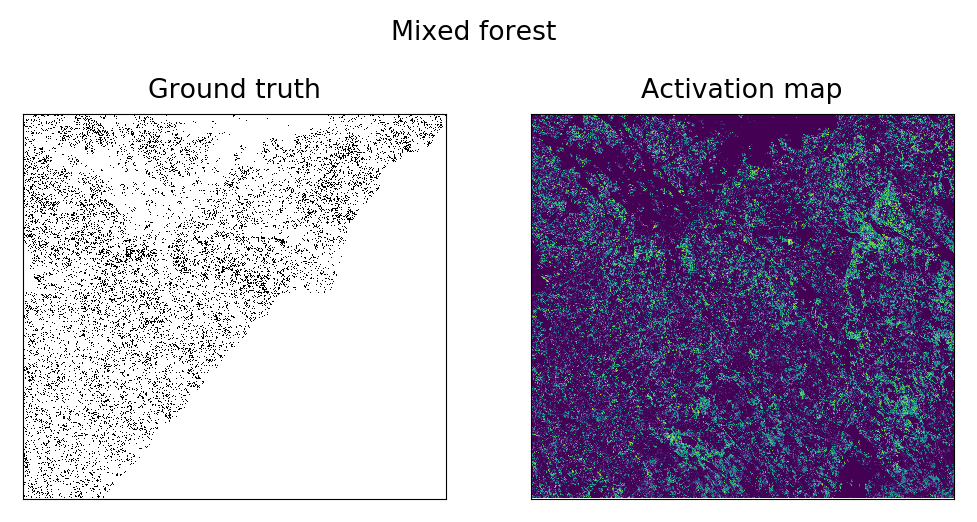

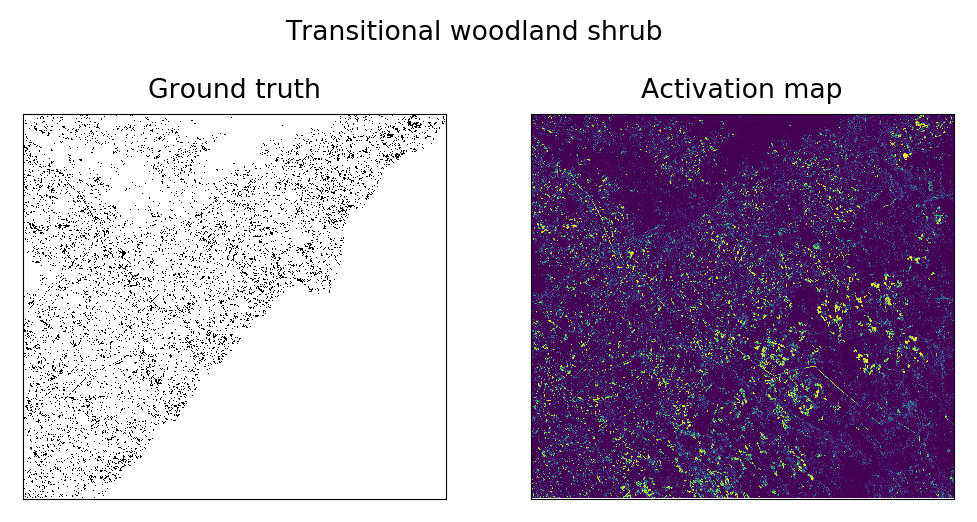

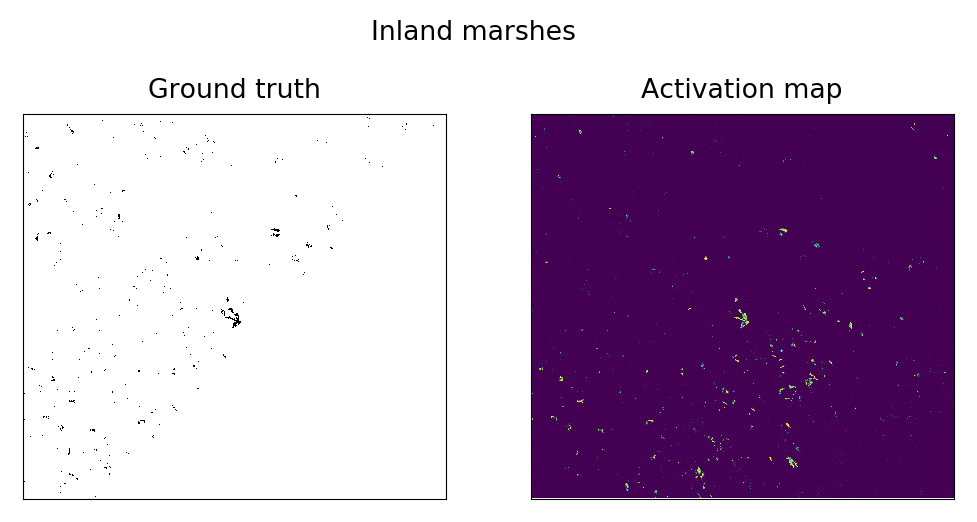

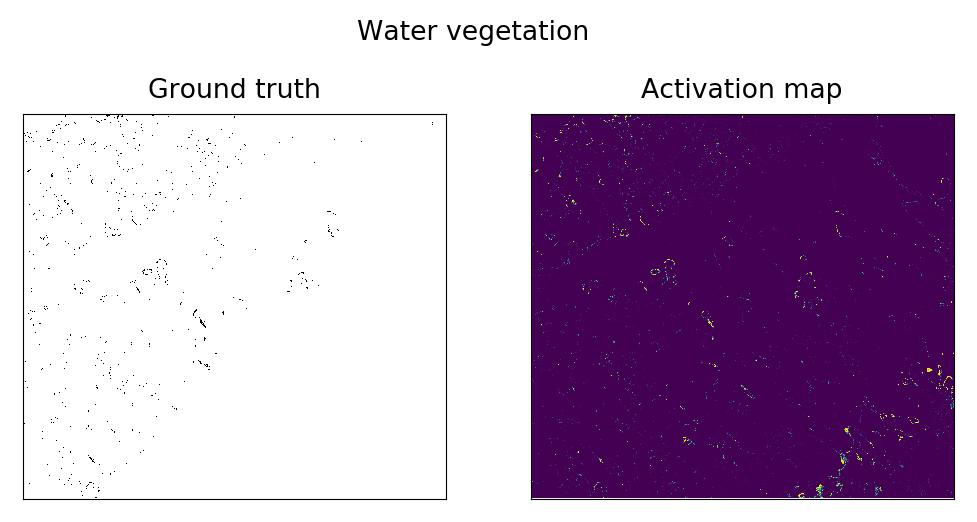

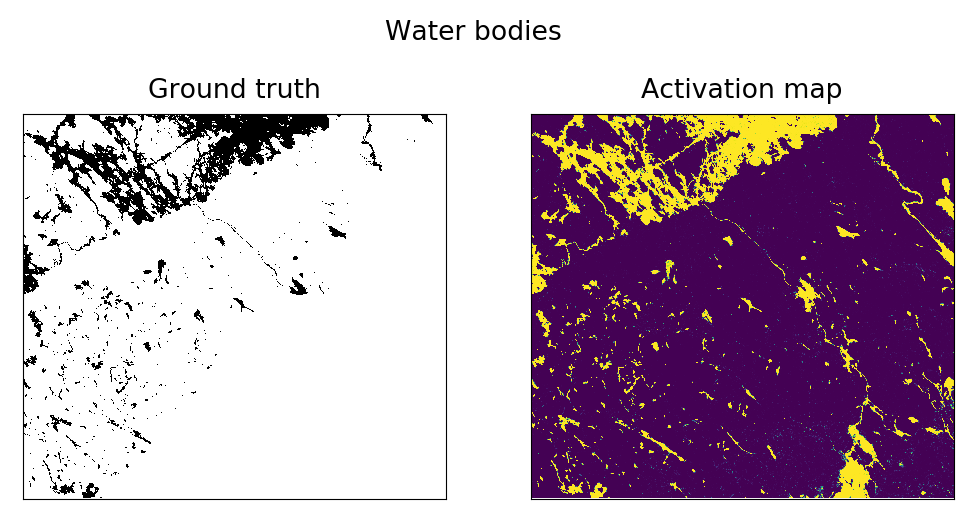

In [44]:
for i in range(13):
    f, ax = plt.subplots(1,2, figsize=(6, 3))
    plt.setp(ax, xticks=[], yticks=[])
    plt.suptitle(f'{reduced_class_names[i]}')
    ax[0].imshow(np.ma.masked_where(truth != i, truth), cmap='binary_r')
    activation_map = full_preds[...,i].copy()
    activation_map[bands[0, ycrop[0]:-ycrop[1], xcrop[0]:-xcrop[1]].values == 0] = 0
    ax[1].imshow(activation_map, cmap='viridis')
    ax[0].set_title('Ground truth')
    ax[1].set_title('Activation map')
    plt.show()

Save arrays as .npy just in case something goes wrong

In [31]:
#np.save('raster.npy', unpadded_image)
#np.save('activation.npy', full_preds)
#unpadded_image = np.load('raster.npy')
#full_preds = np.load('activation.npy')
#unpadded_image.shape, full_preds.shape

Set GeoTransform to fit with cropping, and make numbering start from 1.

In [32]:
out_predictions = unpadded_image.copy()
out_predictions += 1

x_min = indices.attrs['transform'][2] + xcrop[0]*indices.attrs['transform'][0]
y_max = indices.attrs['transform'][-1] + ycrop[0]*indices.attrs['transform'][4]
x_min, y_max

(543040.0, 6786240.0)

Get projection from index data

In [33]:
from osgeo import gdal
from osgeo import osr

indices_for_projection = gdal.Open(test_indices, gdal.GA_ReadOnly)
proj = osr.SpatialReference()
proj.ImportFromWkt(indices_for_projection.GetProjectionRef())
indices_for_projection = None

Save results as GeoTIFF. Note that for some reason whole notebook crashes if filename already exists.

In [34]:

driver = gdal.GetDriverByName('GTiff')
ds = driver.Create('data/raster_kaakonkulma.tif', 6468, 5876, 14, gdal.GDT_Float32)

ds.SetGeoTransform((x_min, 10, 0, y_max, 0, -10))
ds.SetProjection(proj.ExportToWkt())
ds.GetRasterBand(1).WriteArray(out_predictions)

for i in range(2, 15):
    ds.GetRasterBand(i).WriteArray(full_preds[...,i-2])

GDAL closes files by setting them as None

In [35]:
ds = None